In [149]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile
from glob import glob
from scipy.interpolate import griddata
import rasterio
from rasterio.plot import show
from rasterio.features import rasterize
from rasterio.transform import from_origin, xy, rowcol
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.windows import from_bounds
from rasterio.merge import merge
from affine import Affine
from discretize import TensorMesh
from discretize.utils import active_from_xyz
from simpeg.utils import plot2Ddata
from simpeg.potential_fields import gravity, magnetics
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)
from shapely.geometry import Point, Polygon
import psutil
import pyvista as pv
pv.set_jupyter_backend('static')  

In [2]:
output_dir = "/scr/Mineral/AIKosh/JOINT_NEW/OUT_JOINT"
boundary_loc = "/scr/Mineral/AIKosh/JOINT_NEW/Boundary4_Wajra_For_Magnetic_Inversion.bln"  # Use Boundary1 for residual study

In [3]:
topo_filename = "/scr/Mineral/AIKosh/JOINT_NEW/magnetics_topo_100m.txt"
mag_data_filename = "/scr/Mineral/AIKosh/JOINT_NEW/magnetics_data_100m.obs"
grav_data_filename = "/scr/Mineral/AIKosh/JOINT_NEW/gravity_data.obs"

In [4]:
# Load field data
dobs_grav = np.loadtxt(grav_data_filename)
dobs_mag = np.loadtxt(mag_data_filename)
# Load topography (xyz file)
topo_xyz = np.loadtxt(str(topo_filename))

In [5]:
dobs_grav.shape, dobs_mag.shape

((4329, 4), (168391, 4))

In [6]:
# Extract coordinates and values from gravity data
grav_points = dobs_grav[:, :2]          # (x, y) pairs
grav_values = dobs_grav[:, 3]           # gravity values

# Magnetic data coordinates
mag_points = dobs_mag[:, :2]            # (x, y) where we want to interpolate

# Interpolate using linear method (or 'nearest', 'cubic')
interpolated_gravity = griddata(
    grav_points, grav_values, mag_points, method='linear'
)
interpolated_gravity.shape

(168391,)

In [7]:
zeros = np.zeros_like(dobs_mag[:, 0])[:, np.newaxis]  
dobs_grav = np.hstack((mag_points, zeros, interpolated_gravity[:, np.newaxis]))

In [8]:
dobs_grav.shape, dobs_mag.shape

((168391, 4), (168391, 4))

In [9]:
with open(boundary_loc, 'r') as f:
    lines = f.readlines()

boundary_coords = []
for line in lines:
    parts = line.replace(',', ' ').split()
    nums = [float(p) for p in parts]
    boundary_coords.append(nums)

boundary_coords = np.array(boundary_coords)

In [10]:
boundary_polygon = Polygon(boundary_coords)

In [11]:
inside_topo = np.array([boundary_polygon.contains(Point(x, y)) for x, y, z in topo_xyz])
topo_xyz_clipped = topo_xyz[inside_topo]

In [12]:
inside_dobs_grav = np.array([boundary_polygon.contains(Point(x, y)) for x, y, *_ in dobs_grav])
grav_dobs_clipped = dobs_grav[inside_dobs_grav]

In [13]:
inside_dobs_mag = np.array([boundary_polygon.contains(Point(x, y)) for x, y, *_ in dobs_mag])
mag_dobs_clipped = dobs_mag[inside_dobs_mag]

In [14]:
mag_dobs_clipped.shape, grav_dobs_clipped.shape

((3259, 4), (3259, 4))

In [15]:
# Define receiver locations and observed data
receiver_locations = grav_dobs_clipped[:, 0:3]

dobs_grav = grav_dobs_clipped[:, -1]
dobs_mag = mag_dobs_clipped[:, -1]

In [16]:
dobs_mag.shape, dobs_grav.shape

((3259,), (3259,))

In [17]:
receiver_locations.shape

(3259, 3)

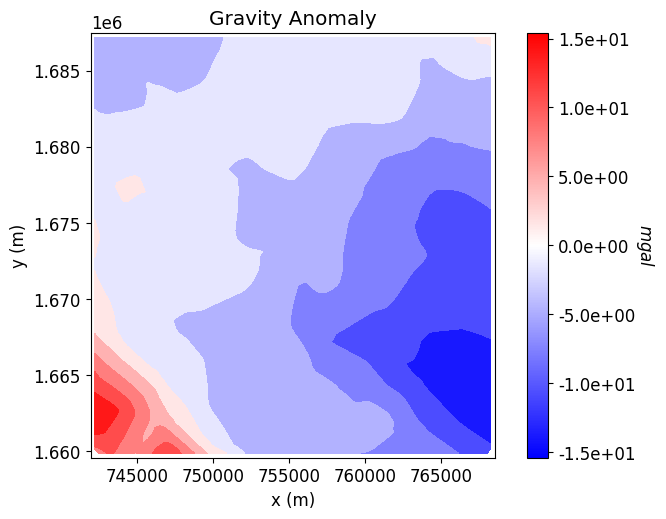

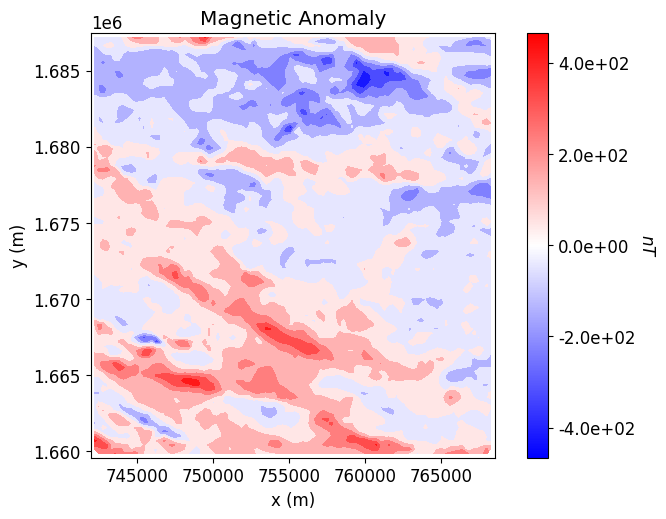

In [18]:
# Plot
mpl.rcParams.update({"font.size": 12})

# gravity data
fig = plt.figure(figsize=(7, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(receiver_locations, dobs_grav, ax=ax1, contourOpts={"cmap": "bwr"})
ax1.set_title("Gravity Anomaly")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.8, 0.1, 0.03, 0.85])
norm = mpl.colors.Normalize(
    vmin=-np.max(np.abs(dobs_grav)), vmax=np.max(np.abs(dobs_grav))
)
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr, format="%.1e"
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

# magnetic data
fig = plt.figure(figsize=(7, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(receiver_locations, dobs_mag, ax=ax1, contourOpts={"cmap": "bwr"})
ax1.set_title("Magnetic Anomaly")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.8, 0.1, 0.03, 0.85])
norm = mpl.colors.Normalize(
    vmin=-np.max(np.abs(dobs_mag)), vmax=np.max(np.abs(dobs_mag))
)
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr, format="%.1e"
)
cbar.set_label("$nT$", rotation=270, labelpad=15, size=12)

plt.show()

In [19]:
maximum_anomaly_grav = np.max(np.abs(dobs_grav))
uncertainties_grav = 0.01 * maximum_anomaly_grav * np.ones(np.shape(dobs_grav))

maximum_anomaly_mag = np.max(np.abs(dobs_mag))
uncertainties_mag = 0.01 * maximum_anomaly_mag * np.ones(np.shape(dobs_mag))

In [20]:
# Define the receivers. The data consist of vertical gravity anomaly measurements.
# The set of receivers must be defined as a list.
receiver_grav = gravity.receivers.Point(receiver_locations, components="gz")

# Define the source field and survey for gravity data
source_field_grav = gravity.sources.SourceField(receiver_list=[receiver_grav])
survey_grav = gravity.survey.Survey(source_field_grav)


# Define the component(s) of the field we want to simulate as a list of strings.
# Here we simulation total magnetic intensity data.
components = ["tmi"]

# Use the observation locations and components to define the receivers. To
# simulate data, the receivers must be defined as a list.
receiver_mag = magnetics.receivers.Point(receiver_locations, components=components)

# Define the inducing field H0 = (intensity [nT], inclination [deg], declination [deg])
inclination = 90
declination = 0
strength = 50000

# Define the source field and survey for gravity data
source_field_mag = magnetics.sources.UniformBackgroundField(
    receiver_list=[receiver_mag],
    amplitude=strength,
    declination=declination,
    inclination=inclination,
)
survey_mag = magnetics.survey.Survey(source_field_mag)

In [21]:
data_object_grav = data.Data(
    survey_grav, dobs=dobs_grav, standard_deviation=uncertainties_grav
)
data_object_mag = data.Data(
    survey_mag, dobs=dobs_mag, standard_deviation=uncertainties_mag
)

In [22]:
x_min, x_max = topo_xyz_clipped[:,0].min(), topo_xyz_clipped[:,0].max()
y_min, y_max = topo_xyz_clipped[:,1].min(), topo_xyz_clipped[:,1].max()
z_min, z_max = topo_xyz_clipped[:,2].min(), topo_xyz_clipped[:,2].max()

print(f"X Range: {x_min:.0f} to {x_max:.0f}")
print(f"Y Range: {y_min:.0f} to {y_max:.0f}")
print(f"Z Range (elevation): {z_min:.0f} to {z_max:.0f}")

X Range: 741948 to 768524
Y Range: 1659564 to 1687502
Z Range (elevation): 382 to 529


In [73]:
dh = 200        #300   or # 200
dz = 200        #200   or # 200
npad = 2      #2
hx = [(dh, npad, -1.3), (dh, 129), (dh, npad, 1.3)]       #85 or #132
hy = [(dh, npad, -1.3), (dh, 136), (dh, npad, 1.3)]        #90 or @139
hz = [(dz, npad, -1.3), (dz, 26)]                         #16  0r #22
mesh = TensorMesh([hx, hy, hz], "CCN")

In [74]:
origin_x = topo_xyz_clipped[:,0].min() - npad * dh
origin_y = topo_xyz_clipped[:,1].min() - npad * dh
origin_z = -5000                 #4000                   #topo_xyz_clipped[:,2].max() + npad * dz

In [75]:
mesh.origin = np.r_[origin_x, origin_y, origin_z]

In [76]:
mesh

TensorMesh: 521,360 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    133    741,548.25    768,544.25    200.00    338.00    1.30
   y    140  1,659,163.97  1,687,559.97    200.00    338.00    1.30
   z     28     -5,000.00        798.00    200.00    338.00    1.30

In [77]:
# Define density contrast values for each unit in g/cc.
background_dens, background_susc = 1e-6, 1e-6

# Find the indicies of the active cells in forward model (ones below surface)
ind_active = active_from_xyz(mesh, topo_xyz_clipped)

# Define mapping from model to active cells
nC = int(ind_active.sum())
model_map = maps.IdentityMap(nP=nC)  # model consists of a value for each active cell

# Create Wires Map that maps from stacked models to individual model components
# m1 refers to density model, m2 refers to susceptibility
wires = maps.Wires(("density", nC), ("susceptibility", nC))

# Define and plot starting model
starting_model = np.r_[background_dens * np.ones(nC), background_susc * np.ones(nC)]

In [249]:
mesh.save("/scr/Mineral/AIKosh/JOINT/OUTPUT/Combined/Tensort_Mesh.json")
np.save("/scr/Mineral/AIKosh/JOINT/OUTPUT/Combined/Active_Tensor_Cells.npy", ind_active )
np.save("/scr/Mineral/AIKosh/JOINT/OUTPUT/Combined/N_Tensor_Active_Cells.npy", nC)

In [78]:
starting_model.shape

(968636,)

In [79]:
simulation_grav = gravity.simulation.Simulation3DIntegral(
    survey=survey_grav,
    mesh=mesh,
    rhoMap=wires.density,
    active_cells=ind_active,
    engine="choclo",
)

simulation_mag = magnetics.simulation.Simulation3DIntegral(
    survey=survey_mag,
    mesh=mesh,
    model_type="scalar",
    chiMap=wires.susceptibility,
    active_cells=ind_active,
    engine="choclo",
)

##### Define the Physics
###### Here, we define the physics of the gravity and magnetic problems by using the simulation class.

##### The inverse problem is defined by 4 things:
###### 1) Data Misfit: a measure of how well our recovered model explains the field data
###### 2) Regularization: constraints placed on the recovered model and a priori information
###### 3) Coupling: a connection of two different physical property models
###### 4) Optimization: the numerical approach used to solve the inverse problem

In [80]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dmis_grav = data_misfit.L2DataMisfit(data=data_object_grav, simulation=simulation_grav)
dmis_mag = data_misfit.L2DataMisfit(data=data_object_mag, simulation=simulation_mag)

# Define the regularization (model objective function).
reg_grav = regularization.WeightedLeastSquares(
    mesh, active_cells=ind_active, mapping=wires.density
)
reg_mag = regularization.WeightedLeastSquares(
    mesh, active_cells=ind_active, mapping=wires.susceptibility
)

# Define the coupling term to connect two different physical property models
lamda = 2e12  # weight for coupling term
cross_grad = regularization.CrossGradient(mesh, wires, active_cells=ind_active)

# combo
dmis = dmis_grav + dmis_mag
reg = reg_grav + reg_mag + lamda * cross_grad

# Define how the optimization problem is solved. Here we will use a projected
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.ProjectedGNCG(
    maxIter=10,
    lower=-2.0,
    upper=2.0,
    maxIterLS=20,
    maxIterCG=100,
    tolCG=1e-3,
    tolX=1e-3,
)

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

In [81]:
# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.PairedBetaEstimate_ByEig(beta0_ratio=1e0)
# starting_beta.n_pw_iter = 10

# Defining the fractional decrease in beta and the number of Gauss-Newton solves
# for each beta value.
beta_schedule = directives.PairedBetaSchedule(cooling_factor=5, cooling_rate=1)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SimilarityMeasureSaveOutputEveryIteration(save_txt=False)

joint_inv_dir = directives.SimilarityMeasureInversionDirective()

stopping = directives.MovingAndMultiTargetStopping(tol=1e-6)

sensitivity_weights = directives.UpdateSensitivityWeights(every_iteration=False)

# Updating the preconditionner if it is model dependent.
update_jacobi = directives.UpdatePreconditioner()


# The directives are defined as a list.
directives_list = [
    joint_inv_dir,
    sensitivity_weights,
    stopping,
    starting_beta,
    beta_schedule,
    save_iteration,
    update_jacobi,
]

In [82]:
def check_memory_feasibility(ind_active, data_object_grav, data_object_mag, threshold_GB=8):
    n_active = int(ind_active.sum())
    n_model = 2 * n_active
    n_data = len(data_object_grav.dobs) + len(data_object_mag.dobs)
    G_bytes = n_data * n_model * 4
    G_GB = G_bytes / (1024**3)

    print("✅ Computational Checkpoint:")
    print(f"  ➤ Active Cells         : {n_active}")
    print(f"  ➤ Model Parameters     : {n_model}")
    print(f"  ➤ Observations         : {n_data}")
    print(f"  ➤ Estimated G Matrix   : {G_GB:.2f} GB (float32)")

    if G_GB > threshold_GB:
        print(f"⚠️ WARNING: Estimated memory exceeds {threshold_GB} GB limit. Consider reducing mesh or data size.")
    else:
        print("✅ OK: Within safe memory limits.")
    print("-" * 60)

# Call it
check_memory_feasibility(ind_active, data_object_grav, data_object_mag)


✅ Computational Checkpoint:
  ➤ Active Cells         : 484318
  ➤ Model Parameters     : 968636
  ➤ Observations         : 6518
  ➤ Estimated G Matrix   : 23.52 GB (float32)
⚠️ WARNING: Estimated memory exceeds 8 GB limit. Consider reducing mesh or data size.
------------------------------------------------------------


In [83]:
# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Run inversion
recovered_model = inv.run(starting_model)


Running inversion with SimPEG v0.23.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    


/scr/anaconda3/envs/mineral/lib/python3.10/site-packages/pymatsolver/wrappers.py:81: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = fun(self.A, **self.kwargs)


model has any nan: 0
============================================================ Projected GNCG ============================================================
  #            betas             lambda      f               phi_d                     phi_m            phi_sim    iterCG    Comment   
---------------------------------------------------------------------------------------------------------------------------------------
x0 has any nan: 0
   0  ['6.74e-02', '2.76e+00']  2.00e+12  4.15e+06             []                        []             0.00e+00      0                
   1  ['8.99e-02', '5.51e-01']  2.00e+12  3.60e+05  ['2.13e+03', '9.56e+04']  ['4.34e+05', '9.22e+04']  8.61e-08    100                
   2  ['1.80e-02', '1.10e-01']  2.00e+12  9.06e+04  ['1.52e+04', '3.31e+04']  ['3.77e+05', '1.49e+05']  9.48e-09    100                
   3  ['3.59e-03', '2.21e-02']  2.00e+12  3.64e+04  ['6.67e+03', '6.23e+03']  ['4.25e+05', '1.90e+05']  8.90e-09    100                
   4  ['

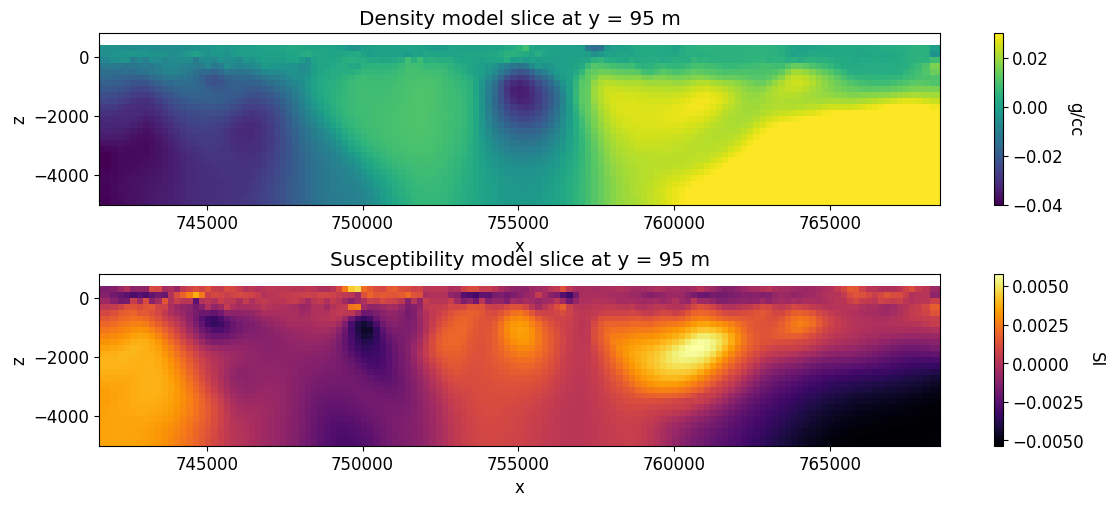

In [246]:
# Plot Recovered Model
m_dens_joint, m_susc_joint = wires * recovered_model
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)
yind = 95
fig = plt.figure(figsize=(12, 5))
ax1 = plt.subplot(211)
(im,) = mesh.plot_slice(
    plotting_map * m_dens_joint,
    normal="Y",
    ind = yind,
    ax=ax1,
    clim=(-0.04, 0.03),
)
ax1.set_title(f"Density model slice at y = {yind} m")
cbar = plt.colorbar(im)
cbar.set_label("g/cc", rotation=270, labelpad=15, size=12)

ax2 = plt.subplot(212)
(im,) = mesh.plot_slice(
    plotting_map * m_susc_joint, normal="Y", ax=ax2, pcolor_opts={"cmap": "inferno"}, ind = yind
)
ax2.set_title(f"Susceptibility model slice at y = {yind} m")
cbar = plt.colorbar(im)
cbar.set_label("SI", rotation=270, labelpad=15, size=12)
ax1.set_aspect(0.95)
ax2.set_aspect(0.95)
plt.tight_layout()
plt.show()

In [85]:
pred_grav = simulation_grav.dpred(recovered_model)
pred_mag  = simulation_mag.dpred(recovered_model)

In [251]:
np.save("/scr/Mineral/AIKosh/JOINT/OUTPUT/Combined/Recovered_Model.npy", recovered_model)
np.save("/scr/Mineral/AIKosh/JOINT/OUTPUT/Combined/Pred_Grav_Model.npy", pred_grav)
np.save("/scr/Mineral/AIKosh/JOINT/OUTPUT/Combined/Pred_Mag_Model.npy", pred_mag)
np.save("/scr/Mineral/AIKosh/JOINT/OUTPUT/Combined/m_dens_joint.npy",m_dens_joint)
np.save("/scr/Mineral/AIKosh/JOINT/OUTPUT/Combined/m_susc_joint.npy",m_susc_joint)

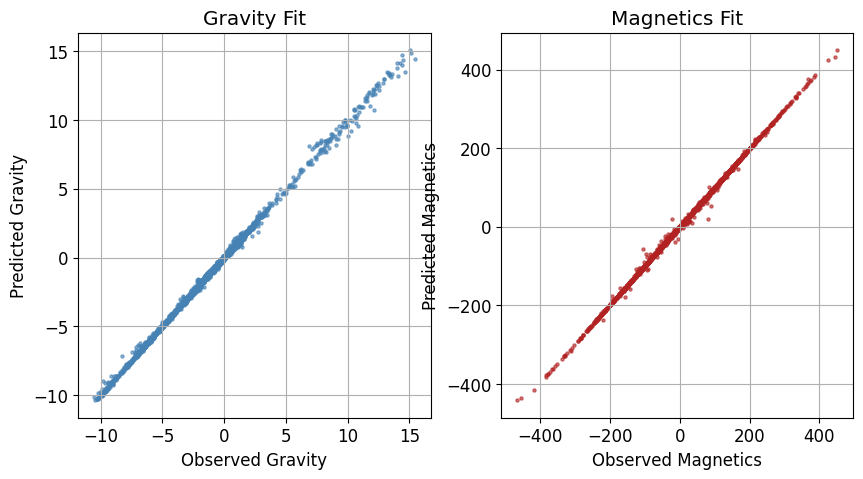

In [86]:
plt.figure(figsize=(10, 5))  # Wide figure for side-by-side plots

plt.subplot(1, 2, 1)
plt.scatter(dobs_grav, pred_grav, s=5, alpha=0.6, color='steelblue')
plt.xlabel("Observed Gravity")
plt.ylabel("Predicted Gravity")
plt.title("Gravity Fit")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(dobs_mag, pred_mag, s=5, alpha=0.6, color='firebrick')
plt.xlabel("Observed Magnetics")
plt.ylabel("Predicted Magnetics")
plt.title("Magnetics Fit")
plt.grid(True)

Text(0.5, 1.0, 'Joint inversion')

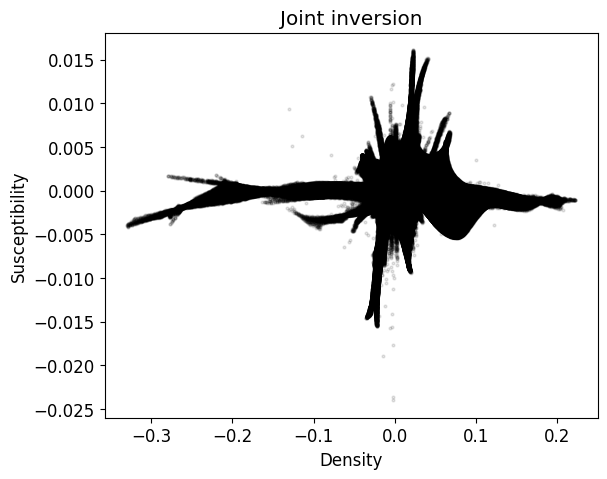

In [87]:
# Cross Plots Recovered Susceptibility and Density Models
fig = plt.figure(figsize=(14, 5))
ax0 = plt.subplot(121)
ax0.scatter(
    plotting_map * m_dens_joint, plotting_map * m_susc_joint, s=4, c="black", alpha=0.1
)

ax0.set_xlabel("Density", size=12)
ax0.set_ylabel("Susceptibility", size=12)
ax0.tick_params(labelsize=12)
ax0.set_title("Joint inversion")


In [89]:
# Compute normalized data misfits
normalized_data_misfits_grav = (dobs_grav - pred_grav) / uncertainties_grav
normalized_data_misfits_mag = (dobs_mag - pred_mag) / uncertainties_grav

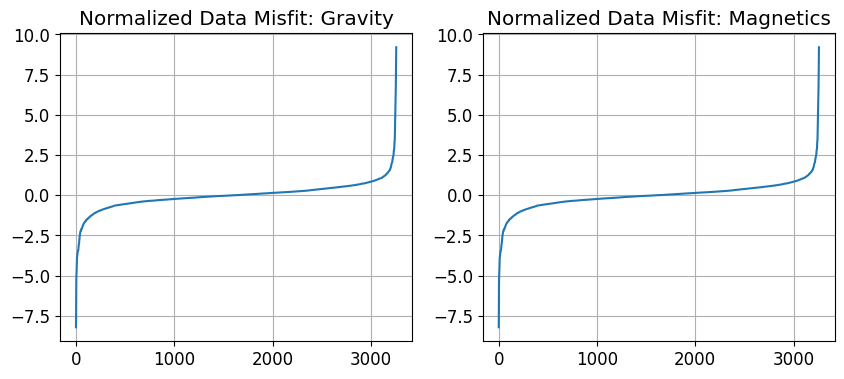

In [94]:
plt.figure(figsize=(10, 4)) 

plt.subplot(1, 2, 1)
plt.plot(np.sort(normalized_data_misfits_grav))

plt.title("Normalized Data Misfit: Gravity")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(np.sort(normalized_data_misfits_grav))

plt.title("Normalized Data Misfit: Magnetics")
plt.grid(True)

In [117]:
plotting_map.shape, recovered_model.shape,m_dens_joint.shape

((521360, 484318), (968636,), (484318,))

In [118]:
# 1. Inject recovered model to full mesh (NaN in inactive)
dens_model_3d = plotting_map * m_dens_joint
susc_model_3d = plotting_map * m_susc_joint

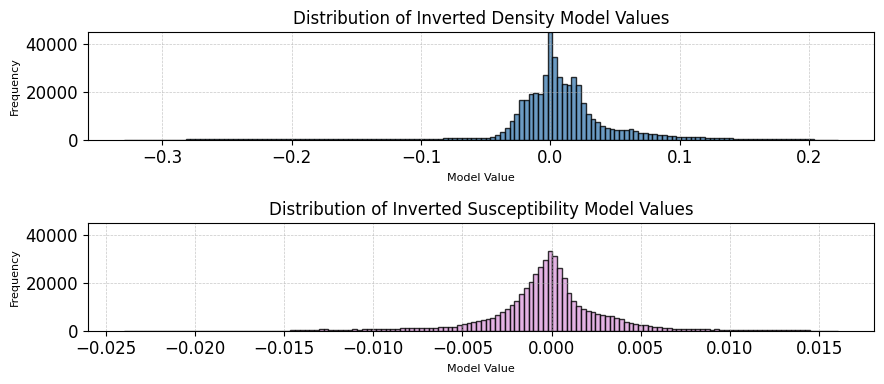

In [142]:
plt.figure(figsize=(9, 4))  
plt.subplot(2, 1, 1)
plt.hist(dens_model_3d, bins=150, color='steelblue', edgecolor='black', alpha=0.8)
plt.title("Distribution of Inverted Density Model Values", fontsize=12)
plt.xlabel("Model Value", fontsize=8)
plt.ylabel("Frequency", fontsize=8)
plt.ylim(0,45000)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.subplot(2, 1, 2)
plt.hist(susc_model_3d, bins=150, color='plum', edgecolor='black', alpha=0.8)
plt.title("Distribution of Inverted Susceptibility Model Values", fontsize=12)
plt.xlabel("Model Value", fontsize=8)
plt.ylabel("Frequency", fontsize=8)
plt.ylim(0,45000)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()

In [240]:
dens_min = 0.01
dens_max = 0.022
susc_min = -0.025
susc_max = -0.015

In [241]:
# 2. Apply mask: only retain values between 0.05 and 0.1
dens_model_masked = np.where((dens_model_3d >= dens_min) & (dens_model_3d <= dens_max), dens_model_3d, np.nan)

# 3. Get voxel centers
x, y, z = mesh.cell_centers[:, 0], mesh.cell_centers[:, 1], mesh.cell_centers[:, 2]
dens_values = dens_model_masked
# 2. Apply mask: only retain values between 0.05 and 0.1
susc_model_masked = np.where((susc_model_3d >= susc_min) & (susc_model_3d <= susc_max), susc_model_3d, np.nan)

# 3. Get voxel centers
xm, ym, zm = mesh.cell_centers[:, 0], mesh.cell_centers[:, 1], mesh.cell_centers[:, 2]
susc_values = susc_model_masked

In [242]:
# 4. Filter only finite (non-NaN) voxels
dens_mask = np.isfinite(dens_values)
dens_points = np.vstack([x[dens_mask], y[dens_mask], z[dens_mask]]).T
dens_values = dens_values[dens_mask]
# 4. Filter only finite (non-NaN) voxels
susc_mask = np.isfinite(susc_values)
susc_points = np.vstack([xm[susc_mask], ym[susc_mask], zm[susc_mask]]).T
susc_values = susc_values[susc_mask]

In [243]:
# 5. Create point cloud for smooth rendering
dens_cloud = pv.PolyData(dens_points)
dens_cloud['density'] = dens_values
# 5. Create point cloud for smooth rendering
susc_cloud = pv.PolyData(susc_points)
susc_cloud['susceptibility'] = susc_values

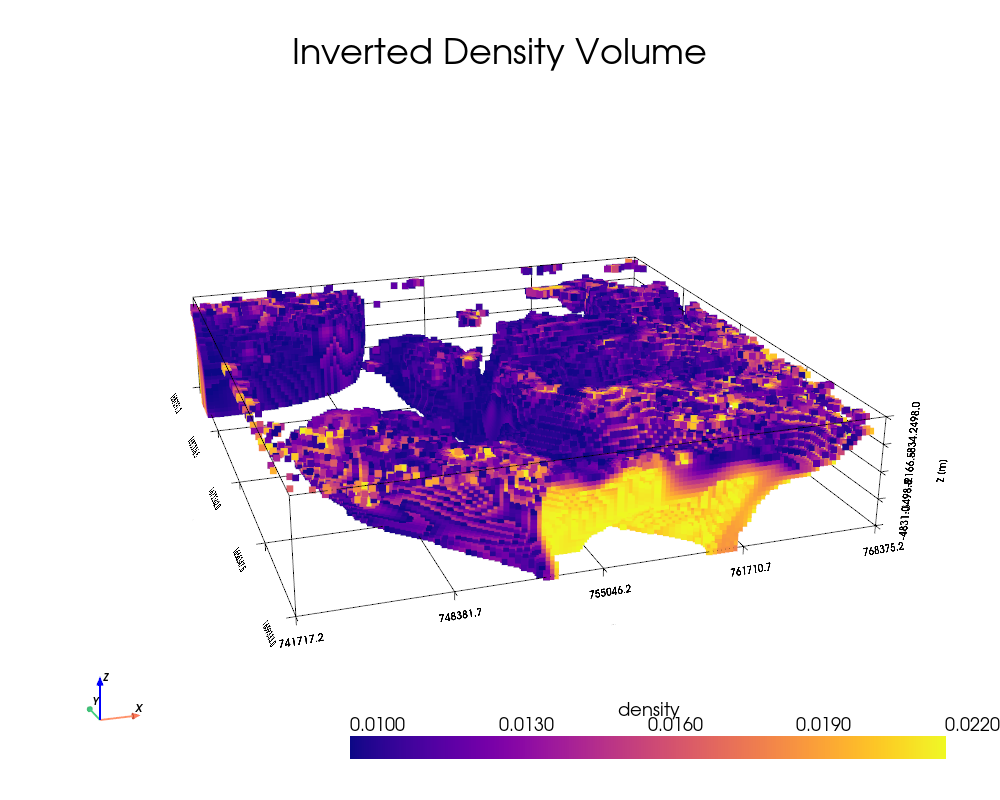

In [244]:
plotter = pv.Plotter(window_size=(1000, 800))      #window_size=(1000, 800)
plotter.add_mesh(dens_cloud,
    scalars='density',
    cmap='plasma',
    render_points_as_spheres=False,
    point_size=7,
    nan_color='white'
)
plotter.add_axes()

plotter.show_bounds(
    grid='back',       # you can try 'all', 'front', 'back'
    location='outer',  # position of ticks
    all_edges=True,
    ticks='outside',
    xtitle='X [m]',
    ytitle='Y [m]',
    ztitle='Z [m]',
    color='black',
    font_size=8
)
plotter.add_title("Inverted Density Volume", font_size=14)
plotter.view_vector([-0.05, -0.15, 0.06])
plotter.show()

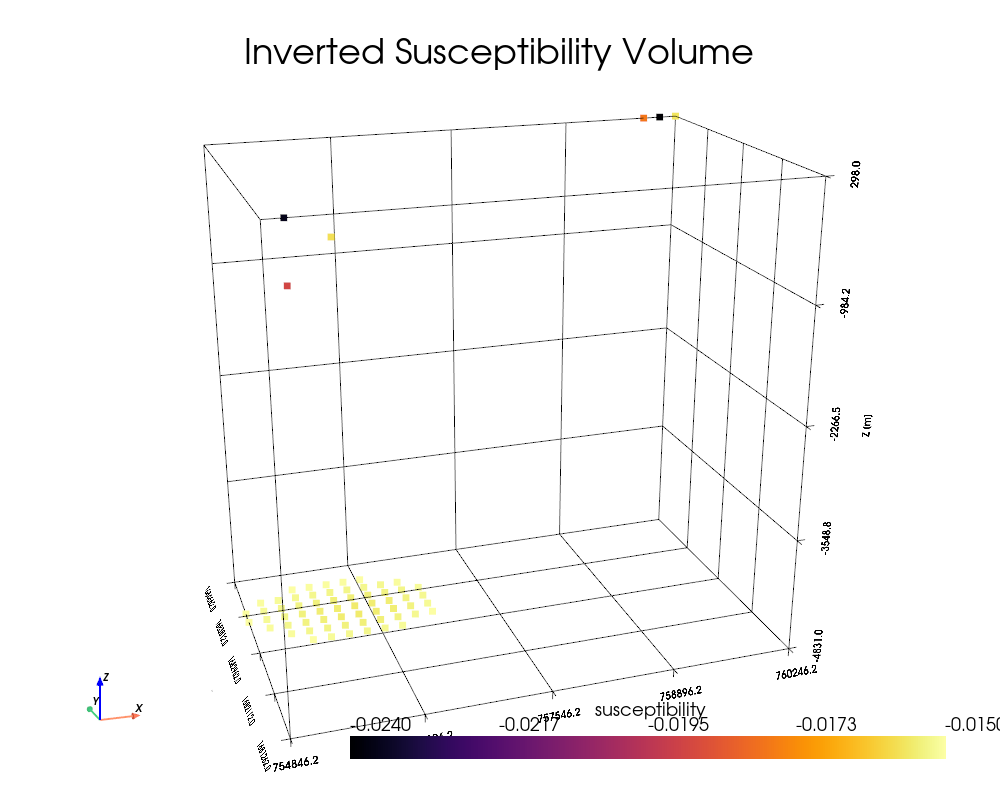

In [245]:
plotter = pv.Plotter(window_size=(1000, 800))      #window_size=(1000, 800)
plotter.add_mesh(susc_cloud,
    scalars='susceptibility',
    cmap='inferno',
    render_points_as_spheres=False,
    point_size=7,
    nan_color='white'
)
plotter.add_axes()

plotter.show_bounds(
    grid='back',       # you can try 'all', 'front', 'back'
    location='outer',  # position of ticks
    all_edges=True,
    ticks='outside',
    xtitle='X [m]',
    ytitle='Y [m]',
    ztitle='Z [m]',
    color='black',
    font_size=8
)
plotter.add_title("Inverted Susceptibility Volume", font_size=14)
plotter.view_vector([-0.05, -0.15, 0.06])
plotter.show()

In [179]:
# Save recovered model as .npy
np.save(r"C:\Data\ONGC\AIKosh\OUTPUT\GM Data\Joint Inversion\recovered_joint_model.npy", recovered_model)

# Optional: separate density and susceptibility components if using Wires
recovered_density = wires.density * recovered_model
recovered_susceptibility = wires.susceptibility * recovered_model

np.save(r"C:\Data\ONGC\AIKosh\OUTPUT\GM Data\Joint Inversion\recovered_density_model.npy", recovered_density)
np.save(r"C:\Data\ONGC\AIKosh\OUTPUT\GM Data\Joint Inversion\recovered_susceptibility_model.npy", recovered_susceptibility)

In [185]:
# Pass full model
predicted_gravity = simulation_grav.dpred(recovered_model)
predicted_magnetic = simulation_mag.dpred(recovered_model)

# Save to disk
np.save(r"C:\Data\ONGC\AIKosh\OUTPUT\GM Data\Joint Inversion\predicted_gravity.npy", predicted_gravity)
np.save(r"C:\Data\ONGC\AIKosh\OUTPUT\GM Data\Joint Inversion\predicted_magnetic.npy", predicted_magnetic)